In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tools

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [64]:
def varBeta(regr, method, lmbd = 0):
    if method == 'ols':
        Bvar = np.sqrt(np.diag(regr.betaVar))
        return Bvar, regr.sigma_y
    if method == 'ridge':
        sigma = regr.sigma_y
        x = regr.symX
        W = np.linalg.inv(x+lmbd*np.eye(x.shape[0]))@x
        Bvar = np.sqrt(np.diag(sigma*W@np.linalg.inv(x)@W.T))
        
        return Bvar, sigma
    else:
        raise ValueError('method needs to be either "ols" or "ridge"')
    

In [4]:
def printvar(regr,Bvar,deg=5):
    mse = regr.squared_error()
    r2 = regr.r2score()
    print('MSE: ', mse)
    print('R2: ', r2)
    print('Conf. int.: ')
    for i in range(len(Bvar)):
        print('B{:}: {:f} {} {:f}'.format(i,regr.beta[i],u'\xb1',Bvar[i]))
        
    df = tools.get_exp_coeffs(beta=regr.beta,deg=deg, print_beta = False)
    plt.imshow(df)
    plt.colorbar()
    plt.xlabel('x order')
    plt.ylabel('y order')
    
    
    return mse,r2

def printvar_lasso(mse,r2,Bvar,reg, deg = 5):
    betas = np.zeros((len(Bvar),))
    print('MSE: ', mse)
    print('R2: ', r2)
    print('Conf. int.: ')
    for i in range(len(Bvar)):
        beta = reg.coef_[i]
        betas[i] = beta
        print('B{:}: {:f} {} {:f}'.format(i,beta,u'\xb1',Bvar[i]))
        
    df = tools.get_exp_coeffs(beta=betas,deg=deg, print_beta = False)
    plt.imshow(df)
    plt.colorbar()
    plt.xlabel('x order')
    plt.ylabel('y order')

## Ordinary linear regression
Make data

In [45]:
deg = 5
N = 2000
lambd = 0.01
noise = 0.1
x,y,z,noise = tools.generate_data(N=N, noise=noise)

X = tools.get_X_poly2D(x,y,deg=deg)

Do regression and print MSE, R2 and beta with conf.int.

In [65]:
# X = tools.get_X_poly2D(x,y,deg=deg)

def olsBeta(X,z, errors = False):
    regr = tools.Regression(X,z,lmbd = 0)

    zpred = regr.yhat
    Bvar,sigma = varBeta(regr,method='ols')
    
    if errors == True:
        mse,r2 = printvar(regr,Bvar)
        
    return regr.beta,Bvar,sigma

In [6]:
## VAR PLoT
# plt.figure(figsize=(10,6))
# plt.subplot(2,2,1)
# plt.imshow(Bvar)
# plt.subplot(1,2,2)
# plt.errorbar(np.arange(len(Bvar)), regr.beta/regr.beta, yerr = np.sqrt(np.diag(Bvar)), fmt=".")
# plt.tight_layout()

In [77]:
df = tools.get_exp_coeffs(Bvar)
df.columns = ['x^{}'.format(i) for i in df.columns]
df.index = ['y^{}'.format(i) for i in df.index]
print(df.to_latex(na_rep='', escape = False,  column_format='lllllll'))

      c:  0.05
    y^1:  0.48
    y^2:  0.47
    y^3:  2.21
    y^4:  1.78
    y^5:  2.20
   x^1 :  4.87
x^1 y^1:  3.69
x^1 y^2:  3.74
x^1 y^3:  4.87
x^1 y^4:  5.06
   x^2 :  3.93
x^2 y^1:  3.67
x^2 y^2:  3.98
x^2 y^3:  5.06
   x^3 :  2.00
x^3 y^1:  1.74
x^3 y^2:  1.71
   x^4 :  1.70
x^4 y^1:  1.75
   x^5 :  1.99
\begin{tabular}{lllllll}
\toprule
{} &       x^0 &       x^1 &       x^2 &       x^3 &       x^4 &       x^5 \\
\midrule
y^0 &  0.045241 &  0.477578 &  0.473107 &  2.211665 &  1.776748 &  2.201117 \\
y^1 &  4.869500 &  3.693231 &  3.737937 &  4.868020 &  5.064018 &           \\
y^2 &  3.927566 &  3.665026 &  3.977169 &  5.062300 &           &           \\
y^3 &  1.995442 &  1.744240 &  1.707438 &           &           &           \\
y^4 &  1.700617 &  1.751833 &           &           &           &           \\
y^5 &  1.987609 &           &           &           &           &           \\
\bottomrule
\end{tabular}



# Ridge regression

In [66]:
# X = tools.get_X_poly2D(x,y,deg=deg)
def ridgeBeta(X,z,lambd, errors = False):
    regr = tools.Regression(X,z,lmbd = lambd)
    
    zpred = regr.yhat
    Bvar,sigma = varBeta(regr,method = 'ridge', lmbd = lambd)

    if errors == True:
        mse,r2 = printvar(regr, Bvar)
    
    return regr.beta, Bvar, sigma
    

# Lasso regression

In [67]:
from sklearn.linear_model import Lasso

def lassoBeta(X,z,lambd, errors = False):
    reg = Lasso(alpha = lambd)
    reg.fit(X,z)
    zpred = reg.predict(X)

    mse = tools.squared_error(z,zpred)
    r2 = tools.r2score(z,zpred)
    sigma = 1/(N-deg-1) * np.sum((z-zpred)**2)
    Bvar = np.sqrt(np.diag(np.linalg.inv(X.T@X)*sigma))
    if errors == True:
        printvar_lasso(mse,r2,Bvar,reg,deg)
        
    return reg.coef_, Bvar, sigma

# Plot beta as a function of lambda
For b_4

Bnum:  0


/Users/heine2307/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:5: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
/Users/heine2307/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:470: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  positive)
/Users/heine2307/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


ValueError: x and y must have same first dimension, but have shapes (50,) and (1,)

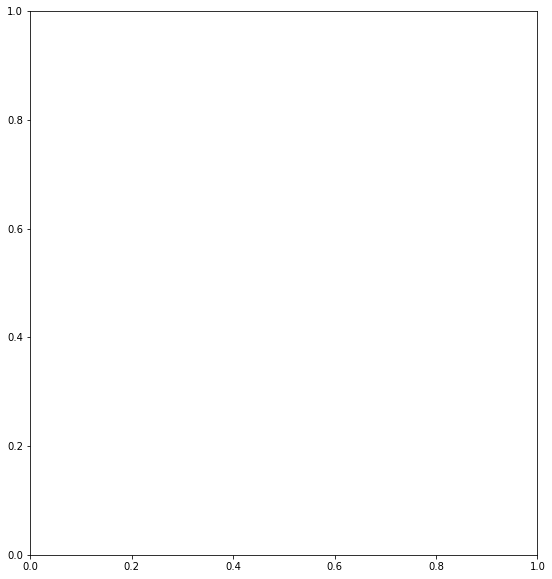

In [106]:
runs = 50
bnum = 10

# OLS beta is not dependent of lambda, so every point is the same
Sb,Sv,Ss = olsBeta(X,z)
Bnum = np.argsort(np.abs(Sb))
bnum = Bnum[0]
print('Bnum: ',bnum)
Sbeta = np.ones(runs)*Sb[bnum]
Svar = np.ones(runs)*Sv[bnum]
Ssig = np.ones(runs)*Ss

Rbeta = np.zeros(runs)
Rvar = np.zeros(runs)
Rsig = np.zeros(runs)

Rlist = np.empty

Lbeta = np.zeros(runs)
Lvar = np.zeros(runs)
Lsig = np.zeros(runs)

Llist = np.empty

#x = 100*np.log10(np.arange(runs))
# x = np.logspace(-3, 2, runs)
x = np.linspace(0, 100, runs)

for i, lambd in enumerate(x):
    #print(lambd)
    Rb,Rv,Rs = ridgeBeta(X,z,lambd=lambd)
    #np.append()
    Rbeta[i] = Rb[bnum]
    Rvar[i] = Rv[bnum]
    Rsig[i] = Rs
    
    Lb,Lv,Ls = lassoBeta(X,z,lambd=lambd)
    Lbeta[i] = Lb[bnum]
    Lvar[i] = Lv[bnum]
    Lsig[i] = Ls

# #OLS
# plt.plot(x,Sbeta, 'r-')
# plt.fill_between(x,Sbeta+Ssig,Sbeta-Ssig,alpha=0.1,color='r')
# #Ridge
# plt.plot(x,Rbeta, 'b-')
# plt.fill_between(x,Rbeta+Rsig,Rbeta-Rsig,alpha=0.1,color='b')
# #Lasso
# plt.plot(x,Lbeta, 'g-')
# plt.fill_between(x,Lbeta+Lsig,Lbeta-Lsig,alpha=0.1,color='g')


# plt.figure(figsize=[20,10])
# plt.subplot(121)
# for i in range(runs):
#     plt.plot(x,Rbeta[i],'b-')
#     plt.fill_between(x,Rbeta[i]+Rsig,Rbeta[i]-Rsig,alpha=0.1,color='b')
# plt.subplot(122)
# for i in range(runs):
#     plt.plot(x,Lbeta[i],'g-')
#     plt.fill_between(x,Lbeta[i]+Lsig,Lbeta[i]-Lsig,alpha=0.1,color='g')

plt.show()
